In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from matplotlib.pyplot import figure
from pandas import ExcelWriter
from pandas import ExcelFile
import glob
import os
%matplotlib inline

from scipy import signal
from scipy.fft import fftshift
from matplotlib import mlab

#%matplotlib inline

# creating 3d plot using matplotlib 
# in python
  
# for creating a responsive plot
#%matplotlib widget
  
# importing required libraries
#from mpl_toolkits.mplot3d import Axes3D
#import matplotlib.pyplot as plt

In [2]:
in_path = "C:/Users/Lisa/Rezanur/Updated SCI/Uni/GT_IDS/Federated Data/In/"
out_path = "C:/Users/Lisa/Rezanur/Updated SCI/Uni/GT_IDS/Federated Data/Out/"
wave_out_path = "C:/Users/Lisa/Rezanur/Updated SCI/Uni/GT_IDS/Federated Data/Wavelet_out/"

In [155]:
# For Data Visualization
Vis_Tesla_Normal = pd.read_csv(out_path + "Vis_Tesla_Normal.csv")
Vis_Tesla_Fuzz_1 = pd.read_csv(out_path + "Vis_Tesla_Fuzz_1.csv")
Vis_Tesla_DoS_2 = pd.read_csv(out_path + "Vis_Tesla_DoS_2.csv")
Vis_Tesla_Replay_1 = pd.read_csv(out_path + "Vis_Tesla_Replay_1.csv")

In [3]:
# Input Data Asign
BMW_Normal = pd.read_csv(out_path + "BMW_Normal_Seg.csv")
Tesla_Normal = pd.read_csv(out_path + "Tesla_Normal_Seg.csv")

Test_Normal_df = pd.read_csv(out_path + "Kia_Normal_Seg.csv")
Train_Normal_df = pd.concat([BMW_Normal, Tesla_Normal],ignore_index=True, axis=0)

BMW_Fuzzing_100 = pd.read_csv(out_path + "BMW_Fuzzing_100_Seg.csv")
BMW_Fuzzing_500 = pd.read_csv(out_path + "BMW_Fuzzing_500_Seg.csv")
Tesla_Fuzz_1 = pd.read_csv(out_path + "Tesla_Fuzz_1_Seg.csv")
Tesla_Fuzz_2 = pd.read_csv(out_path + "Tesla_Fuzz_2_Seg.csv")
Kia_Fuzz_1 = pd.read_csv(out_path + "Kia_Fuzz_1_Seg.csv")
Kia_Fuzz_2 = pd.read_csv(out_path + "Kia_Fuzz_2_Seg.csv")

Train_Fuzz_df = pd.concat([BMW_Fuzzing_100, BMW_Fuzzing_500, Tesla_Fuzz_1, Tesla_Fuzz_2],ignore_index=True, axis=0)
Test_Fuzz_df = pd.concat([Kia_Fuzz_1, Kia_Fuzz_2],ignore_index=True, axis=0)

BMW_DoS_5000 = pd.read_csv(out_path + "BMW_DoS_5000_Seg.csv")
BMW_DoS_10000 = pd.read_csv(out_path + "BMW_DoS_10000_Seg.csv")
Tesla_DoS_2 = pd.read_csv(out_path + "Tesla_DoS_2_Seg.csv")
Tesla_DoS_3 = pd.read_csv(out_path + "Tesla_DoS_3_Seg.csv")
Kia_DoS_2 = pd.read_csv(out_path + "Kia_DoS_2_Seg.csv")
Kia_DoS_3 = pd.read_csv(out_path + "Kia_DoS_3_Seg.csv")

Train_DoS_df = pd.concat([BMW_DoS_5000, BMW_DoS_10000, Tesla_DoS_2, Tesla_DoS_3],ignore_index=True, axis=0)
Test_DoS_df = pd.concat([Kia_DoS_2, Kia_DoS_3],ignore_index=True, axis=0)

BMW_Replay_1 = pd.read_csv(out_path + "BMW_Replay_1_Seg.csv")
BMW_Replay_2 = pd.read_csv(out_path + "BMW_Replay_2_Seg.csv")
Tesla_replay_1 = pd.read_csv(out_path + "Tesla_replay_1_Seg.csv")
Tesla_replay_2 = pd.read_csv(out_path + "Tesla_replay_2_Seg.csv")

Test_Replay_df = pd.read_csv(out_path + "Kia_Replay_Seg.csv")
Train_Replay_df = pd.concat([BMW_Replay_1, BMW_Replay_2, Tesla_replay_1, Tesla_replay_2],ignore_index=True, axis=0)

In [57]:
# Static Value Taken on Every 0.01 Sec
def static_seg_df(df, interval=10):
    df = np.array(df)
    start = df[:,0][0]
    end = interval + start
    entropy = []
    agerage_time_gap = []
    id_count = []
    for ix in df[:,0]:
        a1 = df[(df[:,0] >= start) & (df[:,0] <= end)] 
        entropy.append(len(a1))
        id_count.append(len(np.unique(a1[:,1])))
        agerage_time_gap.append(a1[:,2].mean())
        start = end
        end = start + interval
        
    out = pd.concat([pd.DataFrame(entropy), pd.DataFrame(agerage_time_gap), pd.DataFrame(id_count)], 
                    ignore_index=True, axis=1)
    out = out.rename(columns={0:'Entropy', 1:'Avg_time_gap', 2:'ID_Count'})
    
    return out.dropna()

In [4]:
# 1 Sec Data Taken as Input on Deep Learning Model
def df_seg(in_df):
    out_gt_singale = []
    strat = 0
    limit = 100
    length = len(in_df)
    
    for i in range(strat, length, limit):
        out_gt_singale.append(in_df[strat:limit])
        
    return out_gt_singale

In [54]:
# Wavelet Function Asign
import pywt

def wavelet_1d(data, wavelet='db8', mode='symmetric', level=1):
    # Perform the wavelet transform
    coeffs = pywt.wavedec(data, wavelet, mode, level)
    return coeffs

In [55]:
# High Resolution Feature Extraction From Wavelet Cnversion 
def wavelet_output (in_df, df_label):
    wave_out = pd.DataFrame([0, 0]).T
    segmentation = df_seg(in_df)
    for i in segmentation:
        df_gen_coeffs = wavelet_1d(i['Entropy'])
        df_gen_coeffs = pd.DataFrame(df_gen_coeffs).fillna(0)
        df_timegap_coeffs = wavelet_1d(i['Avg_time_gap'])
        df_timegap_coeffs = pd.DataFrame(df_timegap_coeffs).fillna(0)
        df_ID_Count_coeffs = wavelet_1d(i['ID_Count'])
        df_ID_Count_coeffs = pd.DataFrame(df_timegap_coeffs).fillna(0)
        Final_wave = pd.concat([df_gen_coeffs, df_timegap_coeffs, df_ID_Count_coeffs], ignore_index=True, axis=1)
        wave_out = pd.concat([wave_out, Final_wave],ignore_index=True, axis=0)
    list_label = [df_label] * len(wave_out)
    out = pd.concat([pd.DataFrame(wave_out), pd.DataFrame(list_label)],ignore_index=True, axis=1)
    return out[1:]

In [56]:
# Train Data Processing (BMW, Tesla)
Normal = wavelet_output(Train_Normal_df[:15000],0)
Fuzz = wavelet_output(Train_Fuzz_df,1)
DoS = wavelet_output(Train_DoS_df,1)
Replay = wavelet_output(Train_Replay_df,1)

In [ ]:
Full_df = pd.concat([Normal, Fuzz, DoS, Replay],ignore_index=True, axis=0)
Full_df.shape

In [ ]:
#Full_df.to_csv(wave_out_path+'Wavelet_Bin_Full_df_train.csv', index = False)

In [ ]:
#Full_df.to_csv(wave_out_path+'Wavelet_Mul_Full_df_train.csv', index = False)

In [163]:
# Data Visualization
def plot(df, title):
    time_length = len(df[0])
    time_values = np.linspace(abs(attack_start_time), abs(attack_end_time), time_length)
    x1 = pd.DataFrame(df).shape
    x, y = np.meshgrid(time_values, np.arange(x1[0]))
    fig, ax = plt.subplots()
    im = ax.pcolormesh(x, y, df)
    # Add a colorbar
    fig.colorbar(im)
    ax.set_xlabel('Time (ms)',fontweight="bold")
    ax.set_ylabel('Amplitude',fontweight="bold")
    plt.title(title,fontweight="bold")
    plt.xticks(rotation=45)
    plt.show()

# Normal

In [156]:
attack_start_time = Vis_Tesla_Normal['Time_Ofset'][0]
attack_end_time = Vis_Tesla_Normal['Time_Ofset'][len(Vis_Tesla_Normal['Time_Ofset'])-1]
total_Attack_Time = attack_end_time - attack_start_time

print("Attack Start Time = ", attack_end_time, "(ms)")
print("Attack End Time = ", attack_end_time, "(ms)")
print("Total Attack Time = ", total_Attack_Time, "(ms)")

Attack Start Time =  34999.9 (ms)
Attack End Time =  34999.9 (ms)
Total Attack Time =  2999.800000000003 (ms)


In [157]:
Normal = static_seg_df(Vis_Tesla_Normal)
Normal

C:\Users\Lisa\AppData\Local\Temp\ipykernel_17612\1266812518.py:13: RuntimeWarning: Mean of empty slice.
  agerage_time_gap.append(a1[:,2].mean())
C:\Users\Lisa\anaconda3\lib\site-packages\numpy\core\_methods.py:191: RuntimeWarning: invalid value encountered in longlong_scalars
  ret = ret / rcount


,Entropy,Avg_time_gap,ID_Count
0,38,0.271053,34
1,27,0.374074,27
2,36,0.277778,33
3,26,0.384615,26
4,36,0.277778,33
...,...,...,...
295,27,0.377778,27
296,36,0.283333,32
297,27,0.370370,27
298,36,0.283333,33


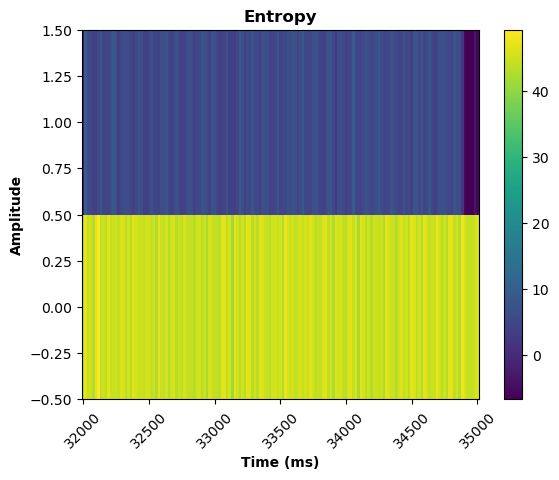

In [164]:
plot(wavelet_1d(Normal["Entropy"]), "Entropy")

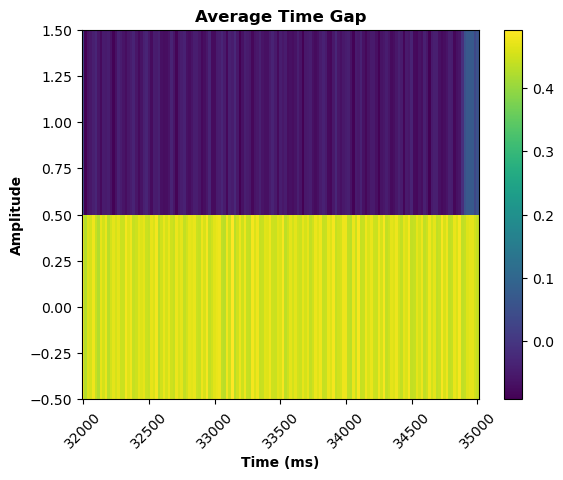

In [165]:
plot(wavelet_1d(Normal["Avg_time_gap"]), "Average Time Gap")

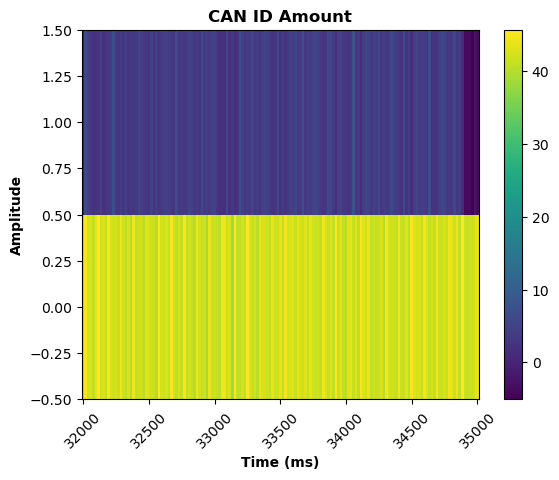

In [166]:
plot(wavelet_1d(Normal["ID_Count"]), "CAN ID Amount")

# Fuzzing

In [133]:
attack_start_time = Vis_Tesla_Fuzz_1['Time_Ofset'][0]
attack_end_time = Vis_Tesla_Fuzz_1['Time_Ofset'][len(Vis_Tesla_Fuzz_1['Time_Ofset'])-1]
total_Attack_Time = attack_end_time - attack_start_time

print("Attack Start Time = ", attack_end_time, "(ms)")
print("Attack End Time = ", attack_end_time, "(ms)")
print("Total Attack Time = ", total_Attack_Time, "(ms)")

Attack Start Time =  215527.2 (ms)
Attack End Time =  215527.2 (ms)
Total Attack Time =  1854.5 (ms)


In [109]:
Fuzz = static_seg_df(Vis_Tesla_Fuzz_1)
Fuzz

C:\Users\Lisa\AppData\Local\Temp\ipykernel_17612\1266812518.py:13: RuntimeWarning: Mean of empty slice.
  agerage_time_gap.append(a1[:,2].mean())
C:\Users\Lisa\anaconda3\lib\site-packages\numpy\core\_methods.py:191: RuntimeWarning: invalid value encountered in longlong_scalars
  ret = ret / rcount


,Entropy,Avg_time_gap,ID_Count
0,582,0.017182,2
1,581,0.017384,2
2,1030,0.009806,3
3,1033,0.009777,3
4,882,0.011451,3
...,...,...,...
181,732,0.012705,33
182,1060,0.010472,32
183,724,0.014365,34
184,1201,0.007993,38


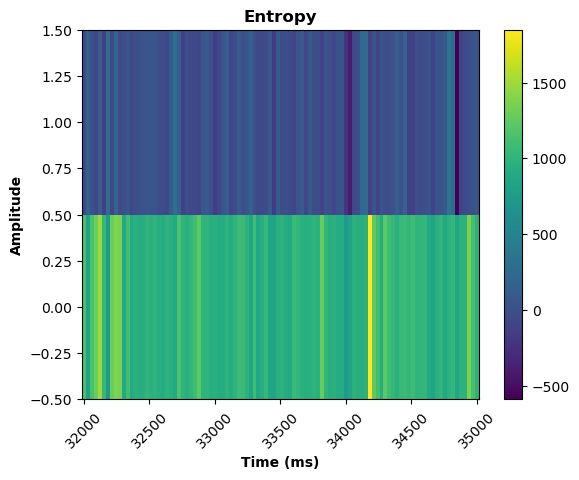

In [167]:
plot(wavelet_1d(Fuzz["Entropy"]), "Entropy")

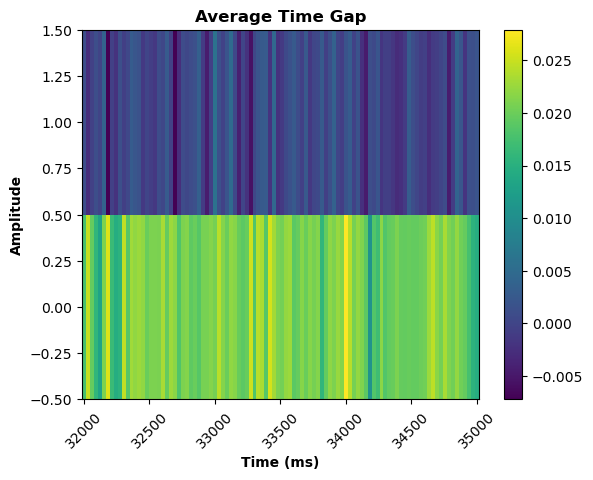

In [168]:
plot(wavelet_1d(Fuzz["Avg_time_gap"]), "Average Time Gap")

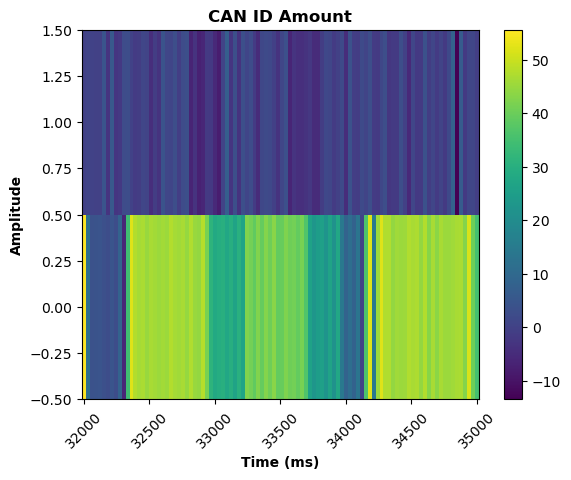

In [169]:
plot(wavelet_1d(Fuzz["ID_Count"]), "CAN ID Amount")

# DoS

In [170]:
attack_start_time = Vis_Tesla_DoS_2['Time_Ofset'][0]
attack_end_time = Vis_Tesla_DoS_2['Time_Ofset'][len(Vis_Tesla_DoS_2['Time_Ofset'])-1]
total_Attack_Time = attack_end_time - attack_start_time

print("Attack Start Time = ", attack_end_time, "(ms)")
print("Attack End Time = ", attack_end_time, "(ms)")
print("Total Attack Time = ", total_Attack_Time, "(ms)")

Attack Start Time =  169499.2 (ms)
Attack End Time =  169499.2 (ms)
Total Attack Time =  1743.2000000000116 (ms)


In [171]:
DoS = static_seg_df(Vis_Tesla_DoS_2)
DoS

C:\Users\Lisa\AppData\Local\Temp\ipykernel_17612\1266812518.py:13: RuntimeWarning: Mean of empty slice.
  agerage_time_gap.append(a1[:,2].mean())
C:\Users\Lisa\anaconda3\lib\site-packages\numpy\core\_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


,Entropy,Avg_time_gap,ID_Count
0,606,0.016502,1
1,633,0.015956,1
2,648,0.015586,1
3,674,0.014985,1
4,679,0.014875,1
...,...,...,...
170,1078,0.009647,1
171,703,0.014367,1
172,718,0.014067,1
173,697,0.014491,1


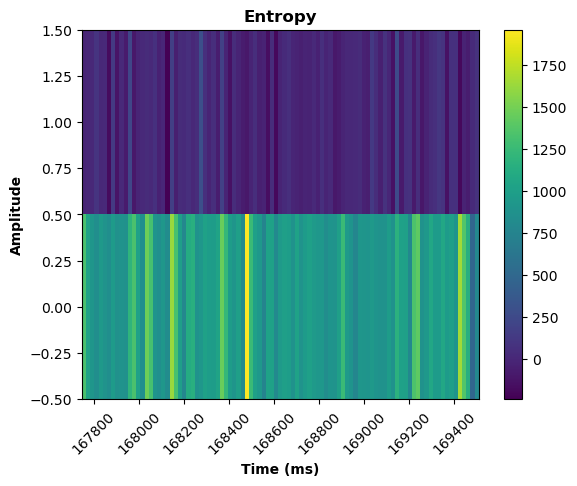

In [172]:
plot(wavelet_1d(DoS["Entropy"]), "Entropy")

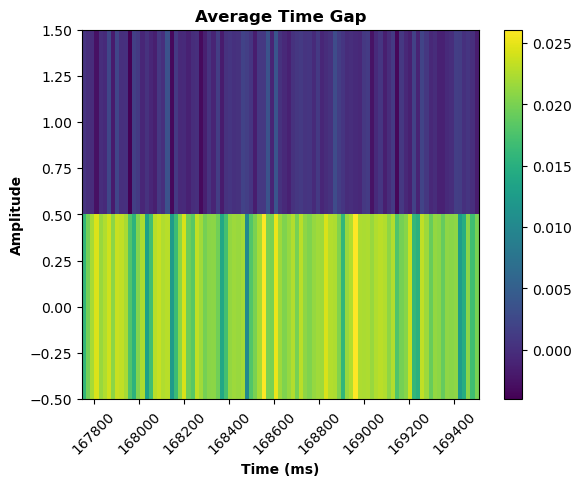

In [173]:
plot(wavelet_1d(DoS["Avg_time_gap"]), "Average Time Gap")

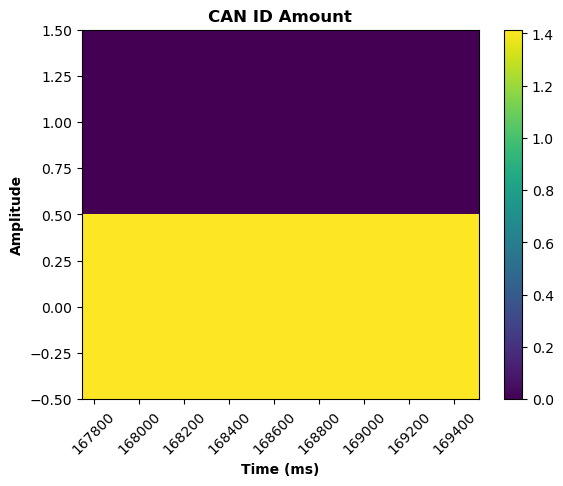

In [174]:
plot(wavelet_1d(DoS["ID_Count"]), "CAN ID Amount")

# Replay

In [175]:
attack_start_time = Vis_Tesla_Replay_1['Time_Ofset'][0]
attack_end_time = Vis_Tesla_Replay_1['Time_Ofset'][len(Vis_Tesla_Replay_1['Time_Ofset'])-1]
total_Attack_Time = attack_end_time - attack_start_time

print("Attack Start Time = ", attack_end_time, "(ms)")
print("Attack End Time = ", attack_end_time, "(ms)")
print("Total Attack Time = ", total_Attack_Time, "(ms)")

Attack Start Time =  185562.1 (ms)
Attack End Time =  185562.1 (ms)
Total Attack Time =  108.60000000000582 (ms)


In [176]:
Replay = static_seg_df(Vis_Tesla_Replay_1)
Replay

C:\Users\Lisa\AppData\Local\Temp\ipykernel_17612\1266812518.py:13: RuntimeWarning: Mean of empty slice.
  agerage_time_gap.append(a1[:,2].mean())
C:\Users\Lisa\anaconda3\lib\site-packages\numpy\core\_methods.py:191: RuntimeWarning: invalid value encountered in longlong_scalars
  ret = ret / rcount


,Entropy,Avg_time_gap,ID_Count
0,62,0.156452,42
1,67,0.168657,41
2,52,0.171154,37
3,32,0.343750,32
4,31,0.332258,30
5,35,0.305714,35
6,29,0.355172,28
7,29,0.351724,29
8,33,0.287879,33
9,32,0.337500,32


C:\Users\Lisa\anaconda3\lib\site-packages\pywt\_multilevel.py:43: UserWarning: Level value of 1 is too high: all coefficients will experience boundary effects.
  warnings.warn(


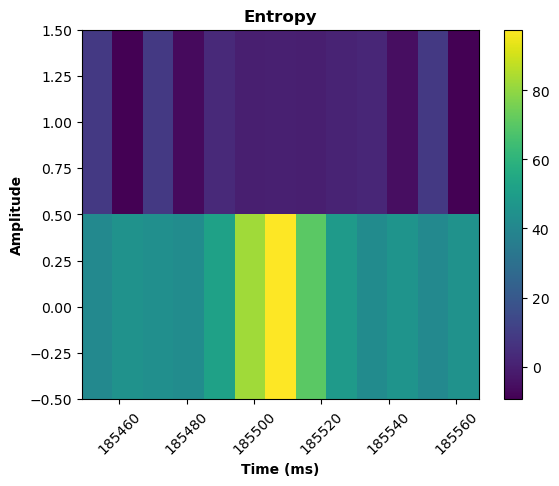

In [177]:
plot(wavelet_1d(Replay["Entropy"]), "Entropy")

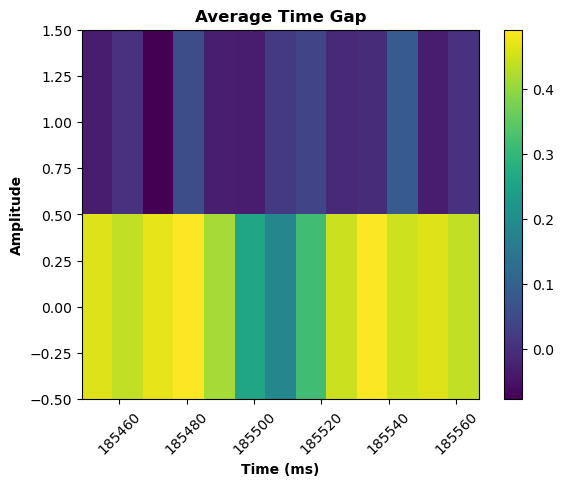

In [178]:
plot(wavelet_1d(Replay["Avg_time_gap"]), "Average Time Gap")

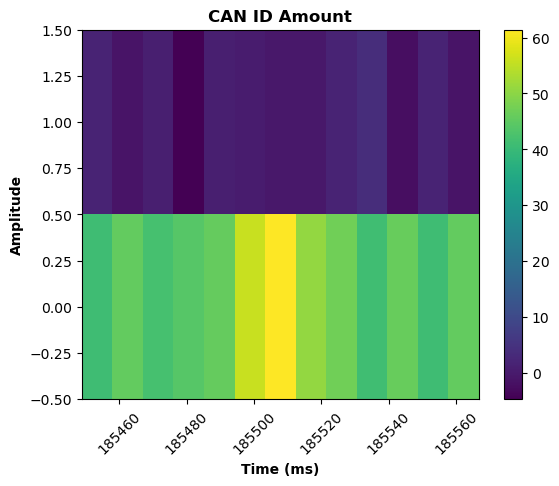

In [179]:
plot(wavelet_1d(Replay["ID_Count"]), "CAN ID Amount")